# Guided Project: Optimizing Model Prediction

### *Lu Yang*

Solution notebook can be referenced [here](https://github.com/dataquestio/solutions/blob/master/Mission764Solutions.ipynb).

## Introduction

For this guided project, we'll take a different approach:

Instead of going with a single model, we'll start with a reference model and then iterate on it using the techniques from this course to optimize it. Our reference model will be a ***standard linear regression*** model, and our machine learning task will be to predict the extent of fire damage to a forest. 

Our data comes from the [Forest Fires dataset](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) from the UCI Machine Learning Repository. This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

In [1]:
## general setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## sklearn setup

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score

In [3]:
fires = pd.read_csv('fires.csv')
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [4]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


The following documentation is available from the source:

1. `X` - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. `Y` - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. `month` - month of the year: 'jan' to 'dec'
4. `day` - day of the week: 'mon' to 'sun'
5. `FFMC` - FFMC index from the FWI system: 18.7 to 96.20
6. `DMC` - DMC index from the FWI system: 1.1 to 291.3
7. `DC` - DC index from the FWI system: 7.9 to 860.6
8. `ISI` - ISI index from the FWI system: 0.0 to 56.10
9. `temp` - temperature in Celsius degrees: 2.2 to 33.30
10. `RH` - relative humidity in %: 15.0 to 100
11. `wind` - wind speed in km/h: 0.40 to 9.40
12. `rain` - outside rain in mm/m2 : 0.0 to 6.4
13. `area` - the burned area of the forest (in ha): 0.00 to 1090.84 (***Target Variable***)

In [5]:
## count missing values

missing_count = fires.isnull().sum(axis = 0)
missing_count

Unnamed: 0     0
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
dtype: int64

The reference model will only use `temp` and `wind` as features, so keep that in mind for later. The outcome of interest is the `area` column, which represents the total area damaged by the fire.

In [6]:
lm_ref = LinearRegression()

## Data Processing

### Examine the distribution of the outcome column: `area`

In [7]:
fires['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

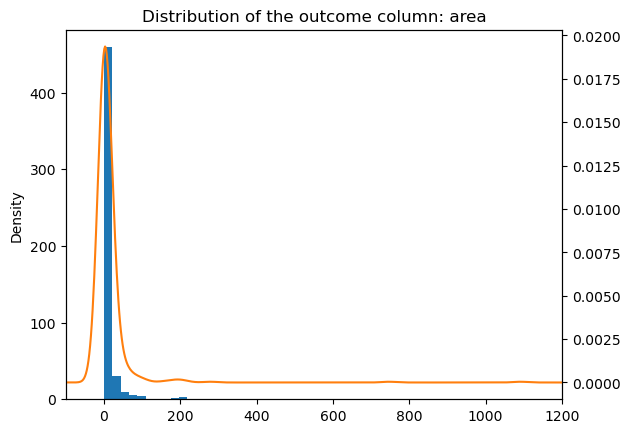

In [8]:
fires['area'].plot.hist(bins = 50)
fires['area'].plot.kde(secondary_y = True)
plt.xlim([-100, 1200])
plt.title('Distribution of the outcome column: area')

plt.show()

The distribution of the `area` column was highly right-skewed, where most values were small but some observations appeared extremely large. This suggested a logarithm transformation to spread out the distribution of the values for `area` more.

However, since the minimum is `0`, we could not compute the logarithmic values until we offset the data by `1` to make sure all values are positive. 

In [9]:
fires['log_area'] = np.log(fires['area'] + 1)

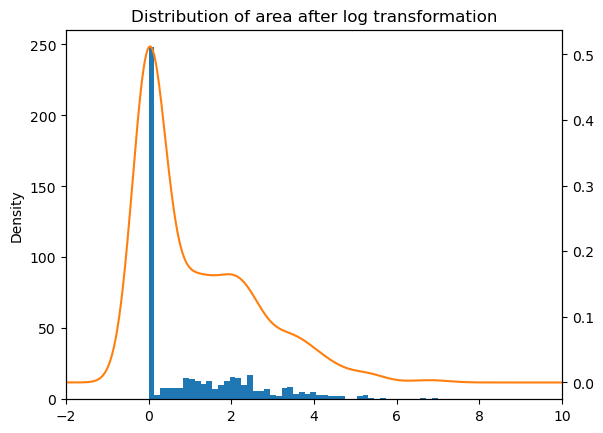

In [10]:
fires['log_area'].plot.hist(bins = 50)
fires['log_area'].plot.kde(secondary_y = True)
plt.xlim([-2, 10])
plt.title('Distribution of area after log transformation')

plt.show()

### Convert `month` and `day`

As there might be some seasonable dependence for the fire, it was assumed that the `month` column was likely more informational. Thus, to reduce the number of unique categories:
* The `day` column will be discarded.
* The `month` column will be reduced to 4 seasons:
	- `mar`, `apr` and `may` -> `spring` 
	- `jun`, `jul` and `aug` -> `summer`
	- `sep`, `oct` and `nov` -> `fall`
    - `dec`, `jan` and `feb` -> `winter`


In [11]:
season_mapper = {
    
    'mar':'spring',
    'apr':'spring',
    'may':'spring',
    'jun':'summer',
    'jul':'summer',
    'aug':'summer',
    'sep':'fall',
    'oct':'fall',
    'nov':'fall',
    'dec':'winter',
    'jan':'winter',
    'feb':'winter'
}

fires['season'] = fires['month'].map(season_mapper)
fires['season'].value_counts()

summer    233
fall      188
spring     65
winter     31
Name: season, dtype: int64

In [12]:
## convert to dummies

fires_season_dummies = pd.get_dummies(fires['season'], prefix = 'season_')
fires_season_dummies

,season__fall,season__spring,season__summer,season__winter
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
512,0,0,1,0
513,0,0,1,0
514,0,0,1,0
515,0,0,1,0


### Impute missing values for numerical columns

In [13]:
cols_to_impute = missing_count[missing_count > 1].index
cols_to_impute

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')

In [14]:
fires.dtypes[cols_to_impute]

FFMC    float64
DMC     float64
DC      float64
ISI     float64
temp    float64
RH      float64
wind    float64
rain    float64
dtype: object

In [15]:
## Use KNN (n = 5) imputer

knn_imputer = KNNImputer(missing_values = np.nan, n_neighbors = 5)

fires_numerical_imputed = pd.DataFrame(knn_imputer.fit_transform(fires[cols_to_impute]), columns = cols_to_impute)
fires_numerical_imputed.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.20,94.30,5.1,15.54,51.0,6.7,0.0
1,90.6,79.28,669.10,6.7,18.00,33.0,0.9,0.0
2,90.6,43.70,438.18,6.7,14.60,33.0,1.3,0.0
3,91.7,33.30,77.50,9.0,8.30,97.0,4.0,0.2
4,89.3,51.30,102.20,9.6,11.40,99.0,4.3,0.0


In [16]:
## confirmed with no missing values

fires_numerical_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFMC    517 non-null    float64
 1   DMC     517 non-null    float64
 2   DC      517 non-null    float64
 3   ISI     517 non-null    float64
 4   temp    517 non-null    float64
 5   RH      517 non-null    float64
 6   wind    517 non-null    float64
 7   rain    517 non-null    float64
dtypes: float64(8)
memory usage: 32.4 KB


In [17]:
fires_numerical_imputed.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.643443,110.933926,545.361857,9.014739,18.903482,44.333462,4.013269,0.021663
std,5.497697,63.315384,242.915696,4.556695,5.744234,15.837848,1.760360,0.295959
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,90.200000,71.000000,440.900000,6.500000,15.540000,33.000000,2.700000,0.000000
50%,91.600000,108.300000,654.100000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,92.900000,141.300000,706.400000,10.700000,22.800000,53.000000,4.900000,0.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


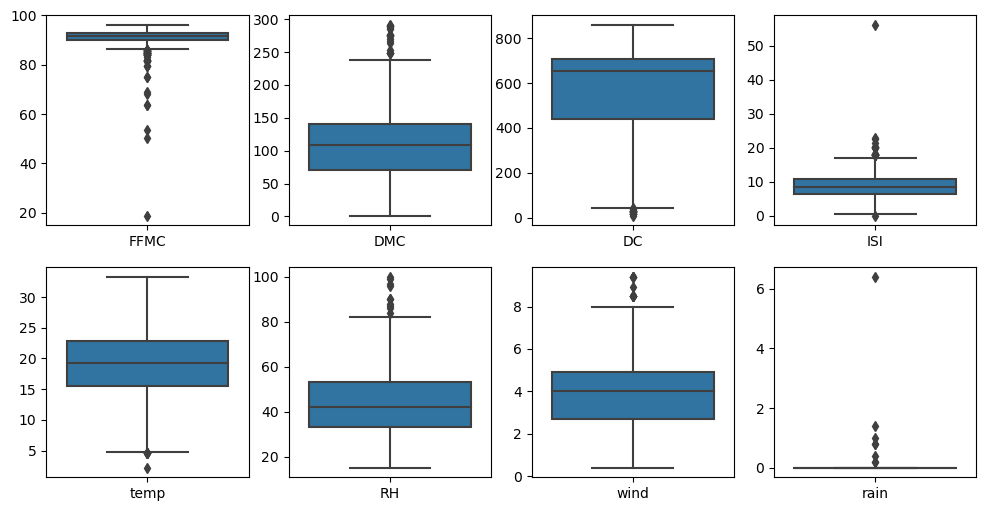

In [18]:
plt.figure(figsize = (12,6))

for i, col in enumerate(cols_to_impute, 1):
    plt.subplot(2,4,i)
    sns.boxplot(data = fires_numerical_imputed[[col]])

Upon imputation, each column more or less appeared to contain a few outliers as shown in their boxplots. At this moment, we could not completely invalidate these datapoints from the documentation, so all datapoints were kept as is. 

In [19]:
## standardizing the features (entire set)

scaler = StandardScaler()
fires_numerical_standardized = pd.DataFrame(scaler.fit_transform(fires_numerical_imputed), 
                                            columns = fires_numerical_imputed.columns)
fires_numerical_standardized.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02
mean,-2.139703e-15,1.765190e-16,-2.190382e-16,1.632049e-16,4.492430e-16,-3.646342e-16,1.250880e-16,-2.841054e-16
std,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00
min,-1.309878e+01,-1.736392e+00,-2.214688e+00,-1.980266e+00,-2.910686e+00,-1.853905e+00,-2.054562e+00,-7.326831e-02
25%,-8.073788e-02,-6.313253e-01,-4.304499e-01,-5.524123e-01,-5.861076e-01,-7.162867e-01,-7.467456e-01,-7.326831e-02
50%,1.741608e-01,-4.164039e-02,4.480709e-01,-1.350396e-01,6.909580e-02,-1.474773e-01,-7.544884e-03,-7.326831e-02
75%,4.108525e-01,4.800647e-01,6.635805e-01,3.702010e-01,6.789926e-01,5.477342e-01,5.042094e-01,-7.326831e-02
max,1.011685e+00,2.851452e+00,1.298983e+00,1.034321e+01,2.508683e+00,3.518183e+00,3.062981e+00,2.157228e+01


### Combine categorical & numerical features

In [20]:
fires_final = pd.concat([fires_season_dummies, fires_numerical_standardized, fires['log_area']], axis = 1)
fires_final.head()

,season__fall,season__spring,season__summer,season__winter,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area
0,0,1,0,0,-0.809020,-1.339580,-1.858664,-0.859950,-0.586108,0.421332,1.527718,-0.073268,0.0
1,1,0,0,0,-0.007910,-0.500425,0.509881,-0.508478,-0.157437,-0.716287,-1.770254,-0.073268,0.0
2,1,0,0,0,-0.007910,-1.062918,-0.441658,-0.508478,-0.749908,-0.716287,-1.542808,-0.073268,0.0
3,0,1,0,0,0.192368,-1.227334,-1.927891,-0.003238,-1.847723,3.328580,-0.007545,0.603155,0.0
4,0,1,0,0,-0.244601,-0.942767,-1.826111,0.128564,-1.307528,3.454982,0.163040,-0.073268,0.0


In [21]:
X = fires_final.drop('log_area', axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season__fall    517 non-null    uint8  
 1   season__spring  517 non-null    uint8  
 2   season__summer  517 non-null    uint8  
 3   season__winter  517 non-null    uint8  
 4   FFMC            517 non-null    float64
 5   DMC             517 non-null    float64
 6   DC              517 non-null    float64
 7   ISI             517 non-null    float64
 8   temp            517 non-null    float64
 9   RH              517 non-null    float64
 10  wind            517 non-null    float64
 11  rain            517 non-null    float64
dtypes: float64(8), uint8(4)
memory usage: 34.5 KB


In [22]:
y = fires_final['log_area']
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 517 entries, 0 to 516
Series name: log_area
Non-Null Count  Dtype  
--------------  -----  
517 non-null    float64
dtypes: float64(1)
memory usage: 4.2 KB


##  Data Visualization

### `log_area` vs Season

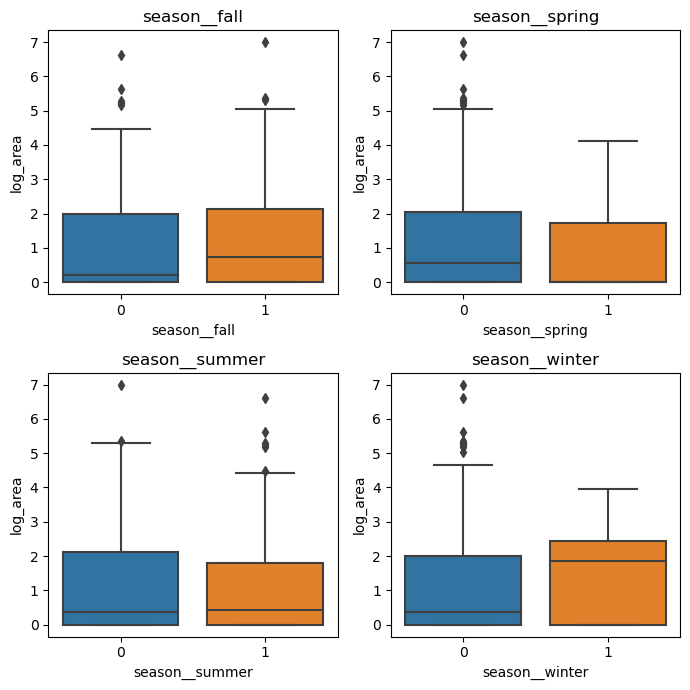

In [23]:
plt.figure(figsize = (7,7))

for i, col in enumerate(fires_season_dummies.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data = fires_final, x = col, y = 'log_area')
    plt.title(f'{col}')

plt.tight_layout()

### `log_area` vs all other numerical features

In [24]:
corrs = fires_final.corr()
corrs

,season__fall,season__spring,season__summer,season__winter,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area
season__fall,1.000000,-0.286661,-0.684699,-0.190917,0.064799,0.042291,0.528370,-0.097929,0.064956,-0.101978,-0.195196,-0.055386,0.069371
season__spring,-0.286661,1.000000,-0.343484,-0.095775,-0.113300,-0.465645,-0.714181,-0.185262,-0.383458,-0.065660,0.199697,-0.023838,-0.071072
season__summer,-0.684699,-0.343484,1.000000,-0.228761,0.214557,0.454234,0.164358,0.370432,0.420271,0.079924,0.017658,0.078261,-0.048816
season__winter,-0.190917,-0.095775,-0.228761,1.000000,-0.422732,-0.387395,-0.417703,-0.319199,-0.476909,0.130818,0.079627,-0.018505,0.060997
FFMC,0.064799,-0.113300,0.214557,-0.422732,1.000000,0.377687,0.344074,0.526084,0.428453,-0.309861,-0.013187,0.048869,0.045852
DMC,0.042291,-0.465645,0.454234,-0.387395,0.377687,1.000000,0.684966,0.303331,0.466810,0.089970,-0.099847,0.075582,0.062352
DC,0.528370,-0.714181,0.164358,-0.417703,0.344074,0.684966,1.000000,0.240749,0.505616,-0.050914,-0.197559,0.037400,0.062045
ISI,-0.097929,-0.185262,0.370432,-0.319199,0.526084,0.303331,0.240749,1.000000,0.391318,-0.132460,0.109850,0.067821,-0.009577
temp,0.064956,-0.383458,0.420271,-0.476909,0.428453,0.466810,0.505616,0.391318,1.000000,-0.511035,-0.217388,0.070063,0.049186
RH,-0.101978,-0.065660,0.079924,0.130818,-0.309861,0.089970,-0.050914,-0.132460,-0.511035,1.000000,0.068153,0.102562,-0.047726


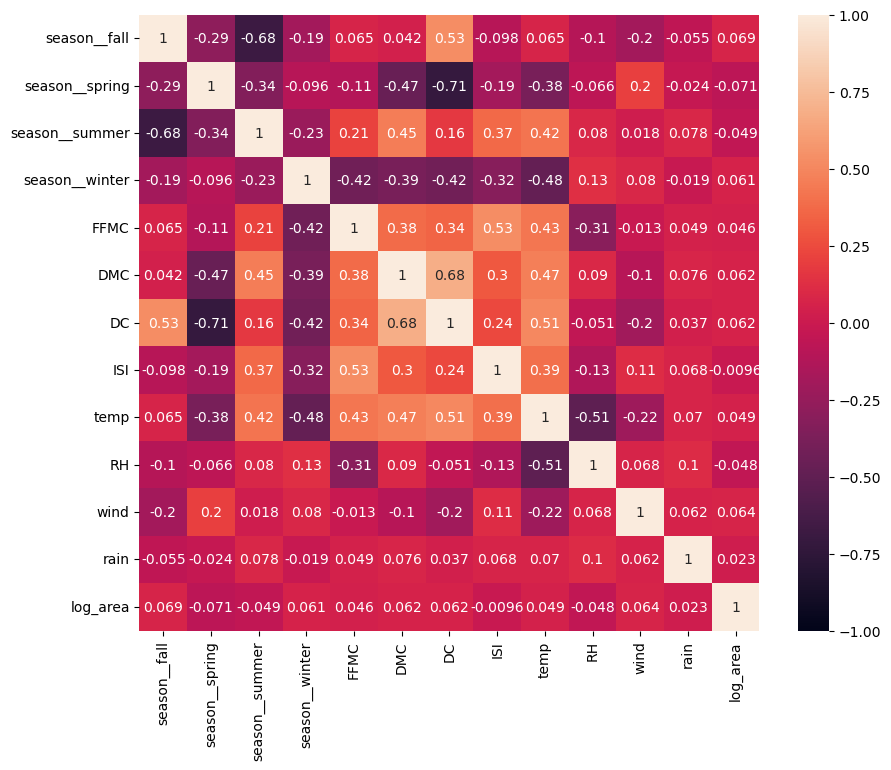

In [25]:
plt.figure(figsize = (10,8))
sns.heatmap(corrs, vmin = -1, vmax = 1, annot = True)
plt.show()

Just by looking at the correlation matrix, there was not a specific feature, whether categorical or numerical, showing significant correlation with the target variable `log_area`.  

## Subset Selection

### Forward selection

Considering we have 12 features in total, we will experiment to reduce the number of features within 2 to 10, by an increment of 2.

In [26]:
lm = LinearRegression()

for n_features in range(2, 12, 2):
    
    forward_selector = SequentialFeatureSelector(lm, n_features_to_select = n_features, 
                                                 direction = 'forward', cv = 5)
    forward_selector.fit(X, y)
    forward_selected = forward_selector.get_feature_names_out()
    
    print(f'The {n_features} features chosen by forward selection are {forward_selected}')

The 2 features chosen by forward selection are ['season__spring' 'FFMC']
The 4 features chosen by forward selection are ['season__spring' 'season__winter' 'FFMC' 'wind']
The 6 features chosen by forward selection are ['season__spring' 'season__winter' 'FFMC' 'DC' 'ISI' 'wind']
The 8 features chosen by forward selection are ['season__spring' 'season__summer' 'season__winter' 'FFMC' 'DC' 'ISI' 'RH'
 'wind']
The 10 features chosen by forward selection are ['season__fall' 'season__spring' 'season__summer' 'season__winter' 'FFMC'
 'DMC' 'DC' 'ISI' 'RH' 'wind']


### Backward selection

In [27]:
for n_features in range(10, 0, -2):
    
    backward_selector = SequentialFeatureSelector(lm, n_features_to_select = n_features, 
                                                 direction = 'backward', cv = 5)
    backward_selector.fit(X, y)
    backward_selected = backward_selector.get_feature_names_out()
    
    print(f'The {n_features} features chosen by forward selection are {backward_selected}')

The 10 features chosen by forward selection are ['season__fall' 'season__spring' 'season__summer' 'season__winter' 'FFMC'
 'DMC' 'DC' 'ISI' 'RH' 'wind']
The 8 features chosen by forward selection are ['season__fall' 'season__spring' 'season__summer' 'season__winter' 'FFMC'
 'DC' 'ISI' 'wind']
The 6 features chosen by forward selection are ['season__fall' 'season__summer' 'season__winter' 'FFMC' 'DC' 'wind']
The 4 features chosen by forward selection are ['season__winter' 'FFMC' 'DC' 'wind']
The 2 features chosen by forward selection are ['season__winter' 'DC']


## Developing Candidate Models

### Reference linear model

In [28]:
lm_ref.fit(X, y)

print(f'Reference linear model results in a r2 score of {lm_ref.score(X, y) :.4f}')
print(f'Intercept:\n{lm_ref.intercept_}')
print(f'Coeffcients:\n{lm_ref.coef_}')

Reference linear model results in a r2 score of 0.0384
Intercept:
1.2757969766104313
Coeffcients:
[-0.00205821 -0.25863118 -0.37658474  0.63727412  0.08623979  0.15518006
 -0.05049575 -0.07204446  0.15749061 -0.00806793  0.14644357  0.01942133]


### Ridge linear models

In [29]:
ridge = RidgeCV(alphas = np.linspace(1, 1000, 100))
ridge.fit(X, y)

print(f'Best alpha value: {ridge.alpha_}, which results in a r2 score of {ridge.score(X,y) :.4f}')
print(f'Intercept:\n{ridge.intercept_}')
print(f'Coeffcients:\n{ridge.coef_}')

Best alpha value: 757.8181818181819, which results in a r2 score of 0.0131
Intercept:
1.114829808742058
Coeffcients:
[ 0.02183286 -0.01565974 -0.0240694   0.01789628  0.0174469   0.02909722
  0.02341686 -0.01904062  0.0178585  -0.02400072  0.0436705   0.01212236]


### Lasso linear models

In [30]:
lasso = LassoCV(alphas = np.linspace(1, 1000, 100))
lasso.fit(X, y)

print(f'Best alpha value: {lasso.alpha_}, which results in a r2 score of {lasso.score(X,y) :.4f}')
print(f'Intercept:\n{lasso.intercept_}')
print(f'Coeffcients:\n{lasso.coef_}')

Best alpha value: 1000.0, which results in a r2 score of 0.0000
Intercept:
1.1110257652960878
Coeffcients:
[ 0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.]


In this case, we found that the Lasso regression resulted in a dummy model whose coefficients were all zeros. The best alpha was found to be the largest value, but further increase in alpha would just increase the regularization and give rise to the same observation with all-zero coefficients. 

### Polynomial models

Considering the large number of features we have, we will only test the quadratic model. 

In [31]:
poly2 = PolynomialFeatures(degree = 2, include_bias = False) ## Fit bias directly in LinearRegression 

X_quadratic = poly2.fit_transform(X)
print(X_quadratic.shape)

(517, 90)


In [32]:
poly2_model = LinearRegression()
poly2_model.fit(X_quadratic, y)

print(f'Quadratic model results in a r2 score of {poly2_model.score(X_quadratic, y) :.4f}')

Quadratic model results in a r2 score of 0.1164


##  K-Fold Cross-Validation

### Reference linear model

In [33]:
lm_ref = cross_val_score(LinearRegression(), X, y, cv = 10, scoring = 'neg_mean_absolute_error')

print(f'For a simple linear model evaluated based on mean absolute error:\n avg {-np.mean(lm_ref) :.4f} \
+- std {np.std(lm_ref) :.4f}')

lm_ref

For a simple linear model evaluated based on mean absolute error:
 avg 1.2538 +- std 0.3613


array([-1.25918344, -1.20831087, -0.96666838, -0.99306677, -2.22502195,
       -1.16084516, -0.86089905, -1.27338722, -1.14869613, -1.44187335])

### 1st candidate - 10 features

We will test out a linear model using the 10 features that were consistently selected by both the forward and backward selection.

In [34]:
features_10 = list(forward_selected)
features_10

['season__fall',
 'season__spring',
 'season__summer',
 'season__winter',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'RH',
 'wind']

In [35]:
lm_10features = cross_val_score(LinearRegression(), X[features_10], y, cv = 10, scoring = 'neg_mean_absolute_error')

print(f'For linear model on 10 selected features evaluated based on mean absolute error:\n avg {-np.mean(lm_10features) :.4f} \
+- std {np.std(lm_10features) :.4f}')

lm_10features

For linear model on 10 selected features evaluated based on mean absolute error:
 avg 1.2349 +- std 0.3450


array([-1.26394799, -1.21228966, -0.96325211, -0.96466074, -2.17079049,
       -1.12501811, -0.86463912, -1.29238232, -1.16359429, -1.32839981])

### 2nd candidate - Ridge linear model

Our 2nd model to test is the ridge regression with the optimized alpha value.

In [36]:
lm_ridge = cross_val_score(Ridge(alpha = ridge.alpha_), X, y, cv = 10, scoring = 'neg_mean_absolute_error')

print(f'For a ridge (l2 regularized) linear model evaluated based on mean absolute error:\n avg {-np.mean(lm_ridge) :.4f} \
+- std {np.std(lm_ridge) :.4f}')

lm_ridge

For a ridge (l2 regularized) linear model evaluated based on mean absolute error:
 avg 1.2136 +- std 0.3459


array([-1.24531395, -1.22933615, -0.9818025 , -0.87834361, -2.14576553,
       -1.08285154, -0.87695856, -1.32259253, -1.09690513, -1.27649296])

### 3rd candidate - Quadratic model

We will lastly evaluate the model with polynomial features (deg = 2). 

In [37]:
lm_poly2 = cross_val_score(LinearRegression(), X_quadratic, y, cv = 10, scoring = 'neg_mean_absolute_error')

print(f'For a simple linear model evaluated based on mean absolute error:\n avg {-np.mean(lm_poly2) :.4f} \
+- std {np.std(lm_poly2) :.4f}')

lm_poly2

For a simple linear model evaluated based on mean absolute error:
 avg 2819284395.3190 +- std 8328386777.7643


array([-2.16393785e+08, -1.35714193e+00, -1.03358998e+00, -1.16030613e+00,
       -8.05212730e+07, -9.22945932e+07, -9.74941474e-01, -1.96674607e+00,
       -1.33771043e+00, -2.78036343e+10])

It was worth noting that the polynomial model was unstable and highly sensitive to the specific set of training data, and thus less preferred than the linear models.

## Examining Model Weaknesses

In [38]:
lm_ridge = Ridge(alpha = ridge.alpha_)
lm_ridge.fit(X, y)

y_pred = lm_ridge.predict(X)

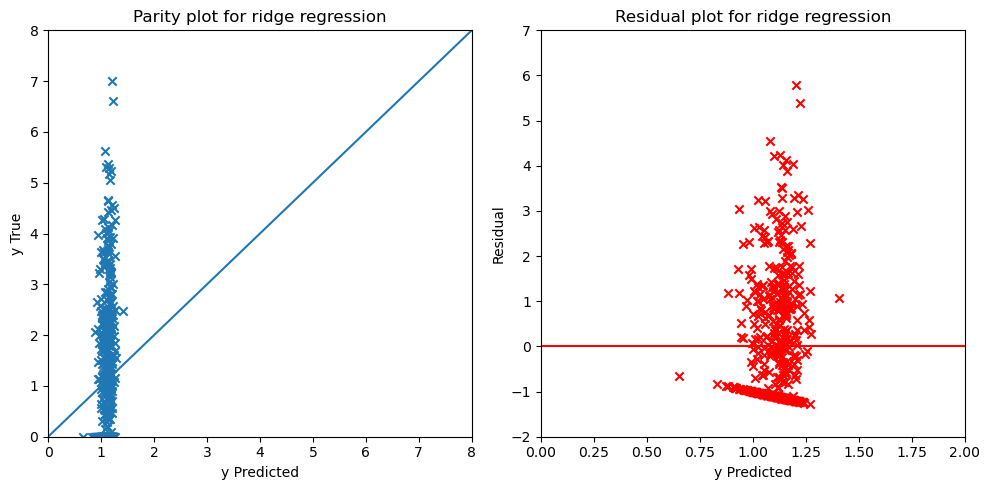

In [39]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.scatter(y_pred, y, marker = 'x')
plt.axline([0,0], slope = 1)
plt.xlabel('y Predicted')
plt.ylabel('y True')
plt.xlim([0,8])
plt.ylim([0,8])
plt.title('Parity plot for ridge regression')

plt.subplot(1,2,2)
plt.scatter(y_pred, y-y_pred, marker = 'x', color = 'red')
plt.axhline(y = 0, color = 'red')
plt.xlabel('y Predicted')
plt.ylabel('Residual')
plt.xlim([0,2])
plt.ylim([-2,7])
plt.title('Residual plot for ridge regression')

plt.tight_layout()